In [1]:
import cv2
import numpy as np
import tensorflow as tf
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D

# Define ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Specify paths to your train, test, and evaluation dataset directories
train_data_dir = 'mrlEyeDataset/train'
test_data_dir = 'mrlEyeDataset/test'
val_data_dir = 'mrlEyeDataset/val'

# Set batch size and image dimensions
batch_size = 32
img_height = 80  # Adjust image height to match dataset
img_width = 80  # Adjust image width to match dataset

# Create data generators from directories
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale')  # Set color_mode to grayscale

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale')  # Set color_mode to grayscale

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale')  # Set color_mode to grayscale


Found 59290 images belonging to 2 classes.
Found 12750 images belonging to 2 classes.
Found 12750 images belonging to 2 classes.


In [2]:
# Define the model
input_tensor = Input(shape=(80, 80, 1))
x = Conv2D(32, (3, 3), activation='relu')(input_tensor)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_tensor, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', 
              metrics=[
                  tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                  tf.keras.metrics.Precision(name='precision'),
                  tf.keras.metrics.Recall(name='recall')
              ])

# Train the model
tensorboard_callback = TensorBoard()
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[tensorboard_callback, early_stopping_callback])



Epoch 1/10

1853/1853 [==============================] - 736s 396ms/step - loss: 0.3378 - accuracy: 0.8420 - precision: 0.8619 - recall: 0.8203 - val_loss: 0.1968 - val_accuracy: 0.9272 - val_precision: 0.8988 - val_recall: 0.9628
Epoch 2/10
1853/1853 [==============================] - 612s 330ms/step - loss: 0.1301 - accuracy: 0.9518 - precision: 0.9603 - recall: 0.9441 - val_loss: 0.1649 - val_accuracy: 0.9477 - val_precision: 0.9792 - val_recall: 0.9148
Epoch 3/10
1853/1853 [==============================] - 312s 168ms/step - loss: 0.0918 - accuracy: 0.9683 - precision: 0.9722 - recall: 0.9651 - val_loss: 0.0970 - val_accuracy: 0.9651 - val_precision: 0.9699 - val_recall: 0.9600
Epoch 4/10
1853/1853 [==============================] - 300s 162ms/step - loss: 0.0771 - accuracy: 0.9728 - precision: 0.9760 - recall: 0.9702 - val_loss: 0.0840 - val_accuracy: 0.9724 - val_precision: 0.9684 - val_recall: 0.9766
Epoch 5/10
1853/1853 [==============================] - 296s 159ms/step - los

In [63]:
import matplotlib.pyplot as plt

test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_generator, steps=len(test_generator))
train_loss, train_accuracy, train_precision, train_recall = model.evaluate(train_generator, steps=len(train_generator))

1853/1853 [==============================] - 211s 114ms/step - loss: 0.0712 - accuracy: 0.9758 - precision: 0.9702 - recall: 0.9825


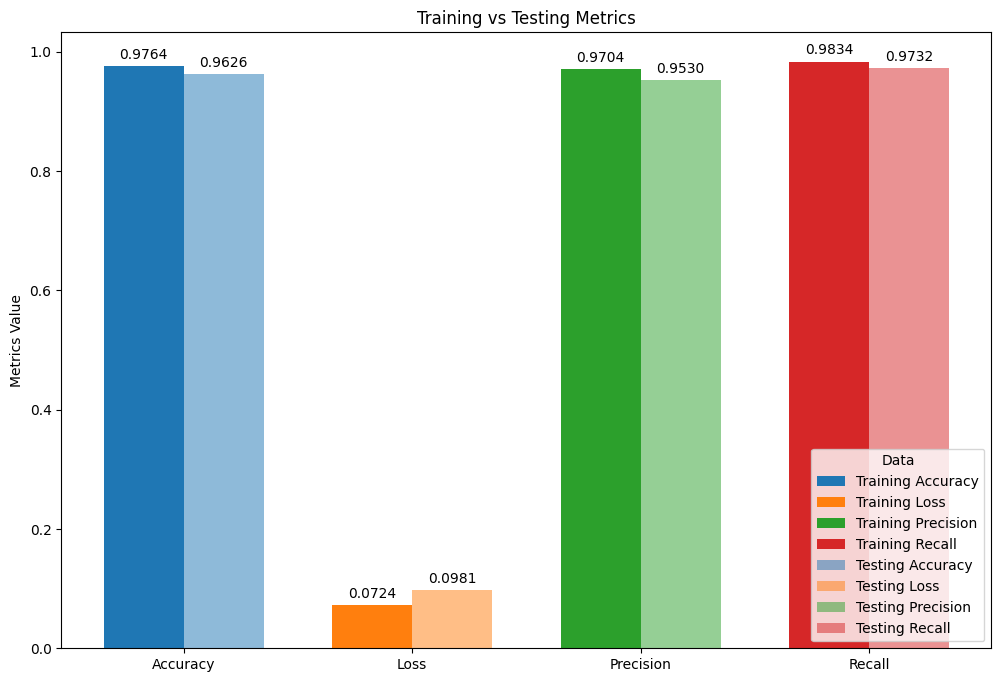

In [62]:
# Create a figure and axis object with a larger figure size
fig, ax = plt.subplots(figsize=(12, 8))

# Define colors for the bars
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Plot each metric as a separate bar
metrics = ['Accuracy', 'Loss', 'Precision', 'Recall']
train_labels = [f'Training {metric}' for metric in metrics]
test_labels = [f'Testing {metric}' for metric in metrics]

train_values = [train_accuracy, train_loss, train_precision, train_recall]
test_values = [test_accuracy, test_loss, test_precision, test_recall]

# Ensure train_values and test_values are 1D arrays
train_values = [val.item() if hasattr(val, 'item') else val for val in train_values]
test_values = [val.item() if hasattr(val, 'item') else val for val in test_values]

bar_width = 0.35
index = range(len(metrics))

# Plot train bars
train_bars = ax.bar([i - bar_width/2 for i in index], train_values, bar_width, label=train_labels, color=colors)

# Plot test bars
test_bars = ax.bar([i + bar_width/2 for i in index], test_values, bar_width, label=test_labels, color=[color + '80' for color in colors])

# Set x-axis labels
ax.set_xticks(index)
ax.set_xticklabels(metrics)

# Add labels to each bar
for bars in [train_bars, test_bars]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Add a title and legend
ax.set_title('Training vs Testing Metrics')
ax.set_ylabel('Metrics Value')
ax.legend(title='Data', loc='lower right')

# display the plot
plt.show()

In [50]:
import cv2
import dlib

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

def apply_clahe(image, clip_limit=2.0, grid_size=(8, 8)):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=grid_size)
    clahe_image = clahe.apply(gray)
    return clahe_image

# Define a function to preprocess the image
def preprocess_image(img_array):
    new_array = cv2.resize(img_array, (80, 80))  # Resize to 80x80
    X_input = np.array(new_array).reshape(-1, 80, 80, 1)  # Add batch dimension
    X_input = X_input / 255.0  # Normalize
    return X_input

# Function to detect eyes using Dlib
def detect_eyes(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    
    eye_regions = []
    for face in faces:
        landmarks = predictor(gray, face)
        
        left_eye_start, left_eye_end = 36, 41
        right_eye_start, right_eye_end = 42, 47
        
        left_eye_pts = landmarks.parts()[left_eye_start:left_eye_end+1]
        right_eye_pts = landmarks.parts()[right_eye_start:right_eye_end+1]
        
        left_eye_x, left_eye_y, left_eye_w, left_eye_h = cv2.boundingRect(np.array([(pt.x, pt.y) for pt in left_eye_pts]))
        right_eye_x, right_eye_y, right_eye_w, right_eye_h = cv2.boundingRect(np.array([(pt.x, pt.y) for pt in right_eye_pts]))
        
        left_eye_region = (left_eye_x, left_eye_y, left_eye_x + left_eye_w, left_eye_y + left_eye_h)
        right_eye_region = (right_eye_x, right_eye_y, right_eye_x + right_eye_w, right_eye_y + right_eye_h)
        
        eye_regions.append(left_eye_region)
        eye_regions.append(right_eye_region)
    
    return eye_regions

In [76]:
import winsound

# Parameters for beep sound
frequency = 2500  # Set frequency to 2500 Hz
duration = 500    # Set duration to 500 ms (0.5 seconds)
best_threshold = 0.5

# Offset percentages for eye region adjustment
offsetPercentageW = 3
offsetPercentageH = 3

# Open webcam
cap = cv2.VideoCapture(0)

while True:
    try:
        # Capture frame-by-frame
        ret, frame = cap.read()
        if not ret:
            print("Failed to capture frame")
            break

        # Detect eyes using Dlib
        eye_regions = detect_eyes(frame)
        predictions = []
        
        # Draw rectangles around the eyes on the frame
        for (x1, y1, x2, y2) in eye_regions:
            offsetW = (offsetPercentageW / 100) * x2
            x1 = int(x1 - offsetW * 2)
            x2 = int(x2 + offsetW * 2)
            offsetH = (offsetPercentageH / 100) * y2
            y1 = int(y1 - offsetH * 3)
            y2 = int(y2 + offsetH * 3.5)
            
            median_filtered_img = cv2.medianBlur(frame, 7)
            brightened_face_roi = cv2.convertScaleAbs(median_filtered_img, alpha=1.5, beta=0)
            clahe_image = apply_clahe(brightened_face_roi)

            # Extract the eye region and preprocess
            eye_region = clahe_image[y1:y2, x1:x2]
            if eye_region.size == 0:  # Check if eye region is empty
                continue

            # Preprocess the extracted eye region
            processed_img = preprocess_image(eye_region)

            # Make prediction
            prediction = model.predict(processed_img) # Extracting the first value of the prediction
            # Display prediction status
            if prediction >= best_threshold:
                cv2.putText(frame, "Awake", (0,20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            else:
                cv2.putText(frame, "Sleepy", (0,20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

            predictions.append(1 if prediction >= best_threshold else 0)

        # If both eyes are detected as "sleepy", sound an alarm
        if len(predictions) == 2 and sum(predictions) == 0:
            winsound.Beep(frequency, duration)

        # Display the frame
        cv2.imshow('Drowsiness Detection', frame)

        # Check for 'q' key to exit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    except Exception as e:
        print(f"Error: {e}")
        break

# Release the capture
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 27ms/step
